# Water Pumps: EDA
## Business Problem:
Tanzania is a developing country and access to water is very important for the health of the population. For this reason, it is vital that all water pumps are properly working. Currently, the only way to monitor pump working status is by physically visiting the site. This is time consuming and costly. Therefore, a more intelligent solution to monitor water pump status is desirable.

This project will address the following question: How can the government of Tanzania improve water pump maintenance by knowing the pump functional status in advance?

## EDA
In this notebook I will:
1. Look for relationships between date recorded and geographical location.
2. Inspect distributions of numerical data.
3. Look for relations between groups of categorical data.

In [1]:
from collections import defaultdict
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from src.viz import viz

%matplotlib inline

## Load Cleaned Data

In [2]:
df = pd.read_csv('../data/clean/cleaned_data.csv', index_col='id')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 0 to 74247
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59364 non-null  object 
 1   amount_tsh             59364 non-null  float64
 2   date_recorded          59364 non-null  object 
 3   funder                 59364 non-null  object 
 4   gps_height             59364 non-null  int64  
 5   installer              59364 non-null  object 
 6   longitude              59364 non-null  float64
 7   latitude               59364 non-null  float64
 8   wpt_name               59364 non-null  object 
 9   num_private            59364 non-null  int64  
 10  basin                  59364 non-null  object 
 11  subvillage             59364 non-null  object 
 12  region                 59364 non-null  object 
 13  region_code            59364 non-null  int64  
 14  district_code          59364 non-null  int64  
 15  lg

## Dates and Geographical location
As indicated during data wrangling, it appears that the geographical locations were recorded twice. I will investigate on whether there is a relationship between when the record was made and the location.

In [4]:
geo_columns = ['longitude', 'latitude']
for column in geo_columns:
    print(df[column].value_counts().to_frame()[column].value_counts())

1       57443
2          72
1777        1
Name: longitude, dtype: int64
1       57445
2          71
1777        1
Name: latitude, dtype: int64


**Observations:**
* The majority of the geographical locations are unique.
* 71 geographical locations are recorded twice.
    * Could these pumps have been recorded on different days?
* One geographical location was recorded 1777 times.
    * This seems suspicious and is worth investigating.

In [5]:
geo_columns = ['longitude', 'latitude']
for column in geo_columns:
    print(df[column].value_counts().to_frame())

           longitude
0.000000        1777
33.010510          2
39.095087          2
39.099069          2
39.085965          2
...              ...
31.789709          1
37.095085          1
39.183964          1
34.341160          1
35.256844          1

[57516 rows x 1 columns]
               latitude
-2.000000e-08      1777
-2.465246e+00         2
-6.957328e+00         2
-6.991294e+00         2
-2.490324e+00         2
...                 ...
-3.263586e+00         1
-9.564592e+00         1
-8.519241e+00         1
-9.342734e+00         1
-2.598965e+00         1

[57517 rows x 1 columns]


**Question:** Does the geographical coordinate that was recorded 1777 times even fall within the borders of Tanzania?

A Google map inspection reveals that these coordinates fall within the Atlantic Ocean! Therefore, they must have been used to indicate pumps with missing geographical information.

In [6]:
1777 / len(df)

0.0299339667138333

Less than three percent of the pumps are missing geographical locations. This is small, but not insignificant.

## Data types
Inspecting the dataset above reveals that the categorical variable data types were lost when converting the file to a csv file. I will re-add them here.

In [7]:
categorical_vars = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code',
                   'lga', 'ward', 'public_meeting', 'permit', 'construction_year',
                   'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group',
                   'payment_type', 'water_quality', 'quality_group', 'quantity_group', 'source', 'source_type', 
                    'source_class', 'waterpoint_type', 'waterpoint_type_group', 'scheme_management', 'status_group', 
                   'payment', 'quantity']

In [8]:
categorical_dict = {x: 'category' for x in categorical_vars}

In [9]:
df = df.astype(categorical_dict)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 0 to 74247
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   status_group           59364 non-null  category
 1   amount_tsh             59364 non-null  float64 
 2   date_recorded          59364 non-null  object  
 3   funder                 59364 non-null  category
 4   gps_height             59364 non-null  int64   
 5   installer              59364 non-null  category
 6   longitude              59364 non-null  float64 
 7   latitude               59364 non-null  float64 
 8   wpt_name               59364 non-null  category
 9   num_private            59364 non-null  int64   
 10  basin                  59364 non-null  category
 11  subvillage             59364 non-null  category
 12  region                 59364 non-null  category
 13  region_code            59364 non-null  category
 14  district_code          59364 non-null 

## Distributions of numerical variables
I will now explore relationshipst between the numerical variables.

**Plan:**
1. Create list of numerical column names.
2. Plot ECDF plots to visualize distributions. Use subplots.

In [11]:
num_cols_list = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

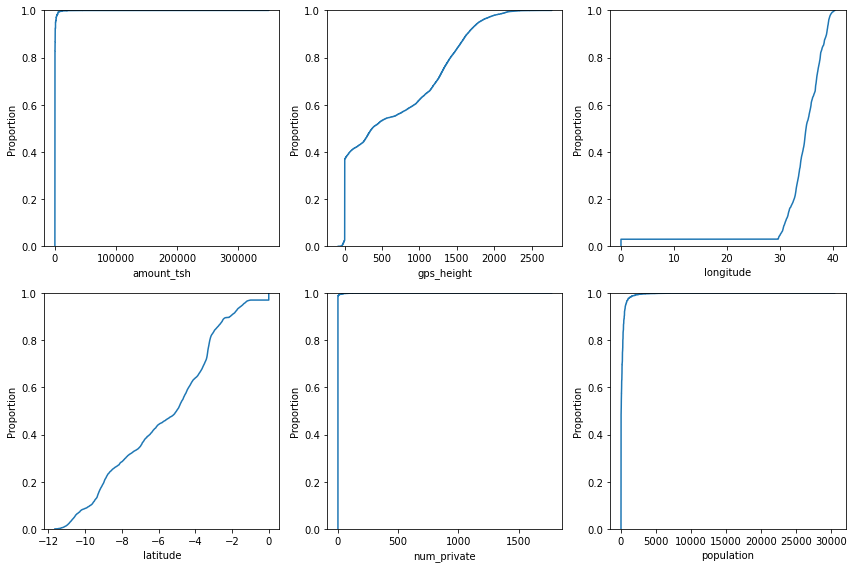

In [12]:
viz.plot_ecdfs(df, num_cols_list, 3)

Plot the ECDFs as before, but exclude all zero values.

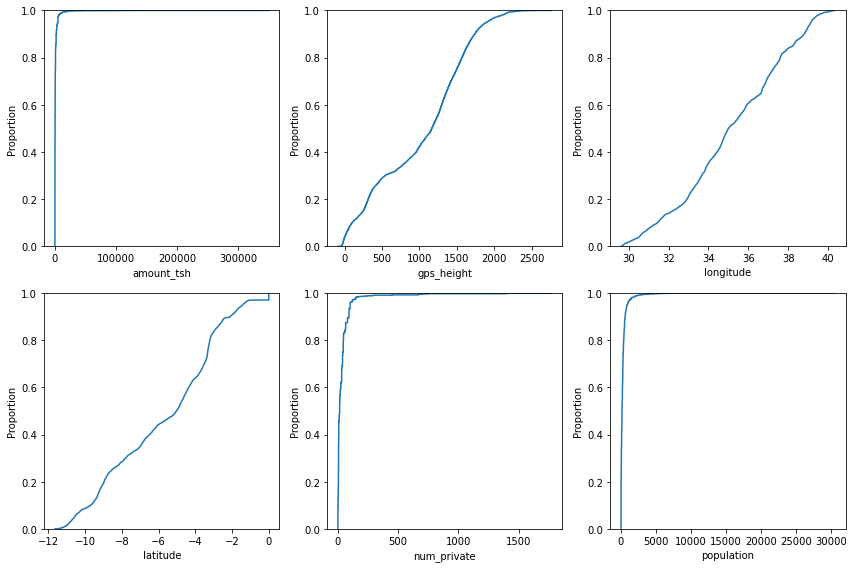

In [13]:
viz.plot_ecdfs(df, num_cols_list, 3, exclude_zeros=True)

**Observations:** The variables `amount_tsh`, `num_private`, and `population` show CDFs that are heavily skewed towards zero.

In [14]:
skewed_columns = ['amount_tsh', 'num_private', 'population']

In [15]:
df[skewed_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
amount_tsh,59364.0,317.843017,2998.473133,0.0,0.0,0.0,20.0,350000.0
num_private,59364.0,0.474429,12.239934,0.0,0.0,0.0,0.0,1776.0
population,59364.0,180.019086,471.604294,0.0,0.0,25.0,215.0,30500.0


One way to deal with these skewed values is to rescale these variables using a log function. I will do this and then relook at the distributions.

In [16]:
for column in skewed_columns:
    df[f'log_{column}'] = np.log(df[column]+1)

In [17]:
log_columns = [f'log_{x}' for x in skewed_columns]

In [18]:
df[log_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
log_amount_tsh,59364.0,1.586196,2.637172,0.0,0.0,0.000000,3.044522,12.765691
log_num_private,59364.0,0.035173,0.341284,0.0,0.0,0.000000,0.000000,7.482682
log_population,59364.0,2.821411,2.662085,0.0,0.0,3.258097,5.375278,10.325515


In [19]:
new_num_cols_list = [f'log_{x}' if x in skewed_columns else x for x in num_cols_list]

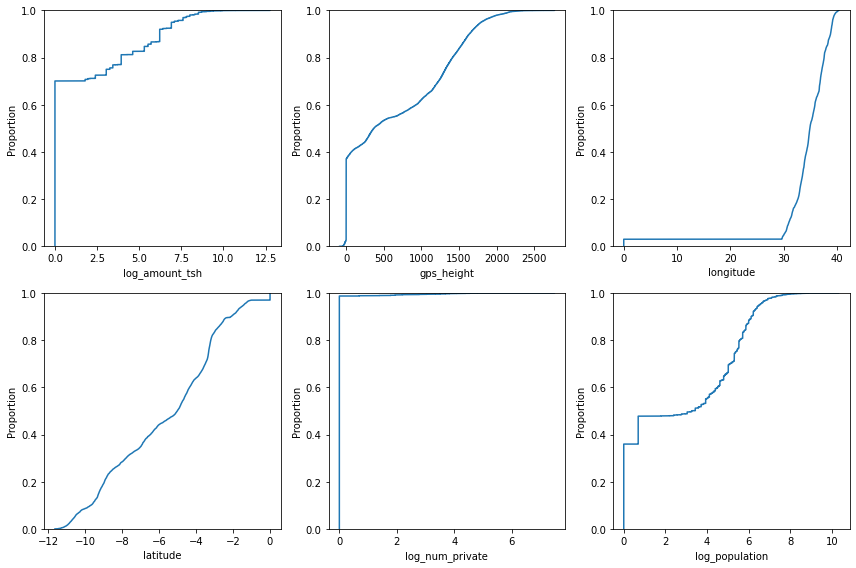

In [20]:
viz.plot_ecdfs(df, new_num_cols_list, 3)

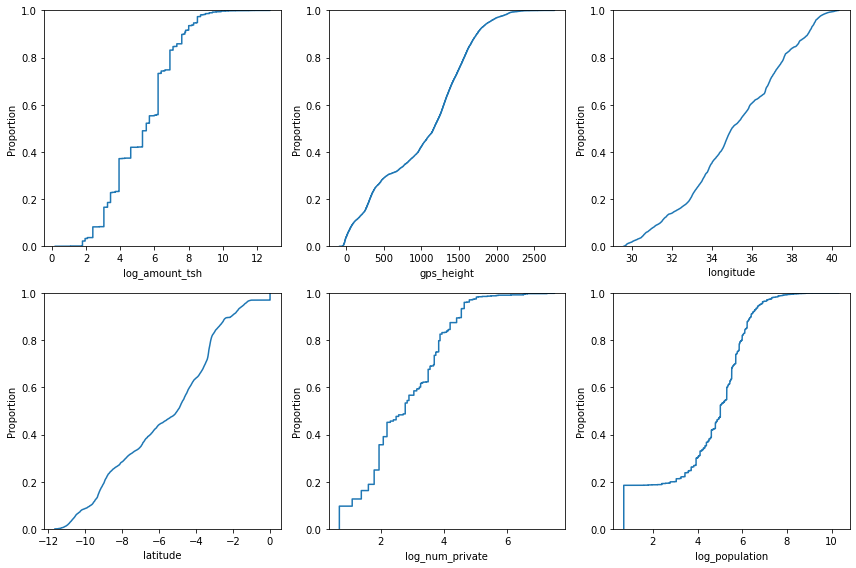

In [21]:
viz.plot_ecdfs(df, new_num_cols_list, 3, exclude_zeros=True)

**Observations:**
That looks much better.
* `log_population`
    * There are many values near zero, but then a nice, normal-looking curve afterwards.
* `log_amount_tsh`
    * A step-wise CDF, starting to increase around 2.
* I also think I only need to consider numerical values that are great than zero. Those that are equal to zero indicate missing values. But, before reaching this conclusion, I need to investigate if there is any relationship between the numerical variables and the response variable and whether the zero values make any difference or not.

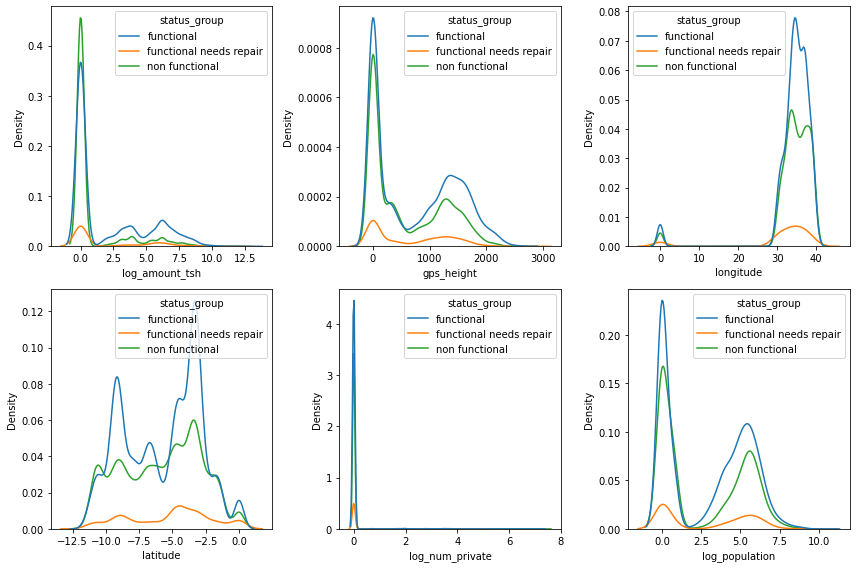

In [22]:
viz.plot_kdes(df, new_num_cols_list, 3)

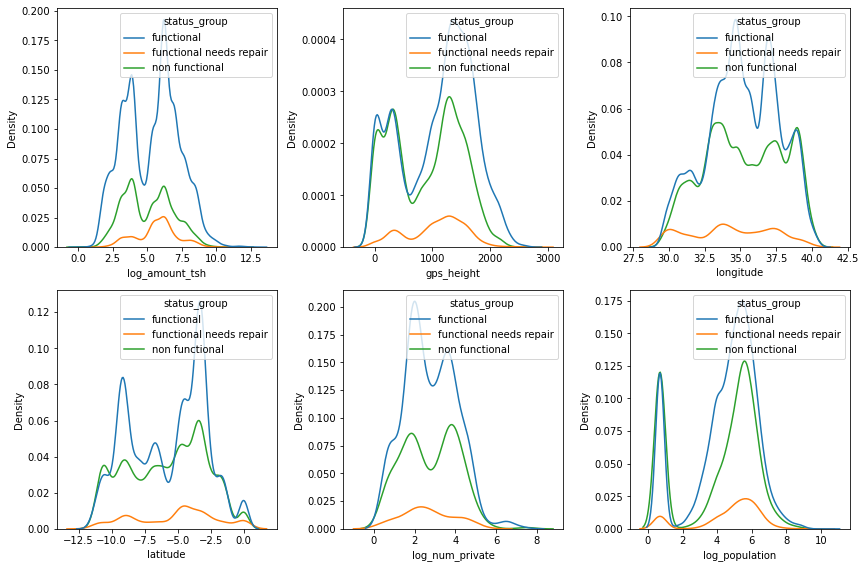

In [23]:
viz.plot_kdes(df, new_num_cols_list, 3, exclude_zeros=True)

In [24]:
# sns.pairplot(df[new_num_cols_list+['status_group']], hue='status_group', plot_kws={"s": 5})
# plt.show()

### Handling zero values
Here, I address correcting for the zero values.

**Plan:**
* longitude
    * Set to median value.
* latitude
    * Set to median value.
* gps_height
    * Set to median value of heights within a binned geographical location.
* log_amount_tsh
    * There are a lot of zero values for the variable. This is the amount of water available at that waterpoint. Using the median `log_amount_tsh` value to resample the zero values seem problematic since there are so many zero values. Is it zero because there really isn't water available, or is it due to missing data?
* log_population
    * This exhibits the same problem as `log_amount_tsh`. But, maybe there are waterpumps in very rural areas.

#### Correcting latitude and longitude:

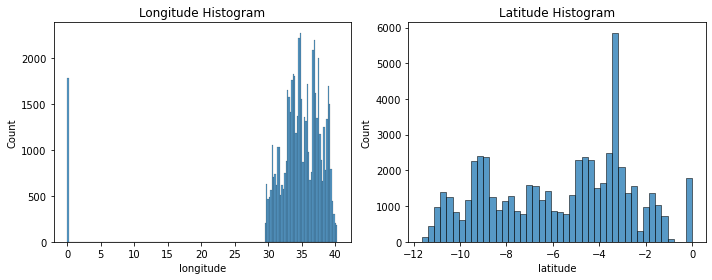

In [25]:
fix, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, column in enumerate(['longitude', 'latitude']):
    sns.histplot(x=column, data=df, ax=ax[i])
    ax[i].set_title(f'{column.title()} Histogram')
plt.tight_layout()
plt.show()

**Plan:**
1. Find median values for non-zero latitude/longitude.
2. Set zero latitude/longitude values to median value.

In [26]:
location_columns = ['longitude', 'latitude']
for column in location_columns:
    non_zero = df[column] != 0.0
    median_location = np.median(df.loc[non_zero, column])
    df.loc[~non_zero, column] = median_location

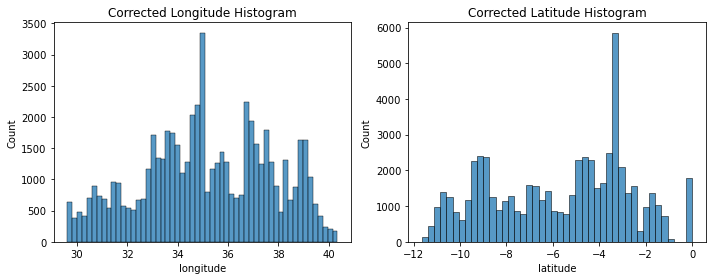

In [27]:
fix, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, column in enumerate(['longitude', 'latitude']):
    sns.histplot(x=column, data=df, ax=ax[i])
    ax[i].set_title(f'Corrected {column.title()} Histogram')
plt.tight_layout()
plt.show()

**Observations:**
There is still an extreme value in latitude. This value is:

In [28]:
df['latitude'].max()

-2e-08

I will correct for these outlier values by setting any latitude value above -0.5 to the median latitude for the country.

In [29]:
limit = -0.5
outlier_latitudes = df['latitude'] > limit
print(f'There are {np.sum(outlier_latitudes)} values above the {limit} latitude.')
fraction_over_limit = np.sum(outlier_latitudes) / len(df)
print(f'There is a {fraction_over_limit:0.2f} fraction of values in this dataset that are about the latitude limit.')

There are 1777 values above the -0.5 latitude.
There is a 0.03 fraction of values in this dataset that are about the latitude limit.


In [30]:
df.loc[outlier_latitudes, 'latitude'] = df['latitude'].median()

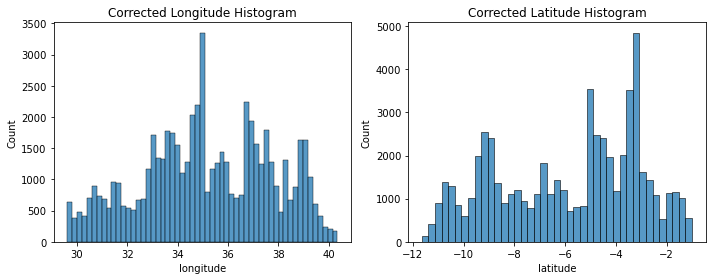

In [31]:
fix, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, column in enumerate(['longitude', 'latitude']):
    sns.histplot(x=column, data=df, ax=ax[i])
    ax[i].set_title(f'Corrected {column.title()} Histogram')
plt.tight_layout()
plt.show()

#### Correct Heights:
**Plan:**
1. Create a unique location identifier by combining latitude and longitude.
2. Bin DataFrame by this identifier.
3. Compute median heights for non-zero heights that fall within each bin.
4. Set zero values in each bin to the median height for that bin.

In [32]:
df['eq_distance'] = np.sqrt(df['latitude']**2 + df['longitude']**2)

In [33]:
num_bins = 1000
bin_labels = [f'bin_{x}' for x in range(num_bins)]
df['binned_distance'] = pd.cut(df['eq_distance'], bins=num_bins, labels=bin_labels)

In [34]:
total_bins_created = len(df['binned_distance'].unique())
bin_size = len(df) / total_bins_created
print(f'There are {total_bins_created} bins created.')
print(f'There average number of points per bin is {bin_size:0.3f}.')

There are 998 bins created.
There average number of points per bin is 59.483.


In [35]:
df['gps_height_corrected'] = df['gps_height']
for distance_bin in df['binned_distance'].unique().sort_values():
    nonzero_heights = (df['binned_distance'] == distance_bin) & (df['gps_height'] != 0)
    if np.sum(nonzero_heights) > 0:
        median_height = np.median(df.loc[nonzero_heights, 'gps_height'])
    zero_heights = (df['binned_distance'] == distance_bin) & (df['gps_height'] == 0)
    if np.sum(zero_heights) > 0:
        df.loc[zero_heights, 'gps_height_corrected'] = median_height

In [36]:
# sns.pairplot(df[['gps_height', 'gps_height_corrected', 'latitude', 'longitude', 'status_group']], hue='status_group', plot_kws={"s": 5})
# plt.show()

In [37]:
num_cols_list_corrected = [f'{x}_corrected' if x == 'gps_height' else x for x in new_num_cols_list]

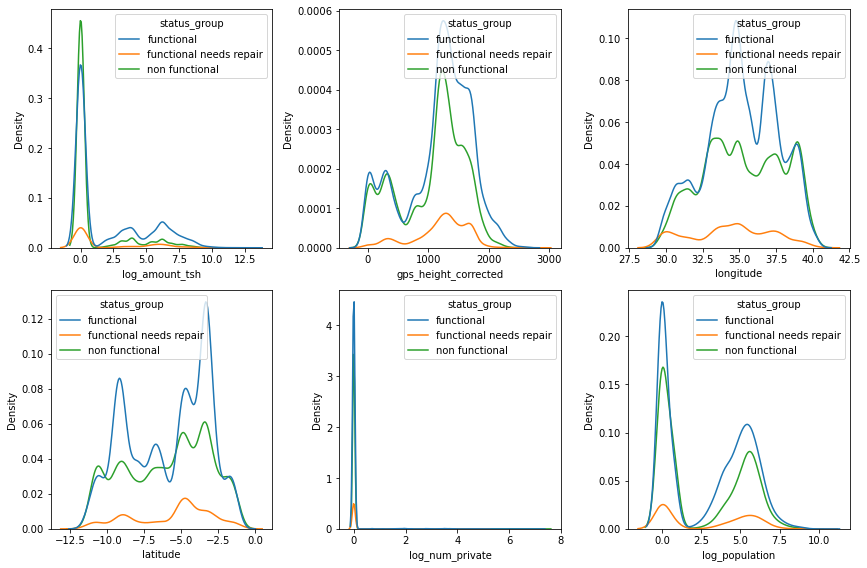

In [38]:
viz.plot_kdes(df, num_cols_list_corrected, 3)

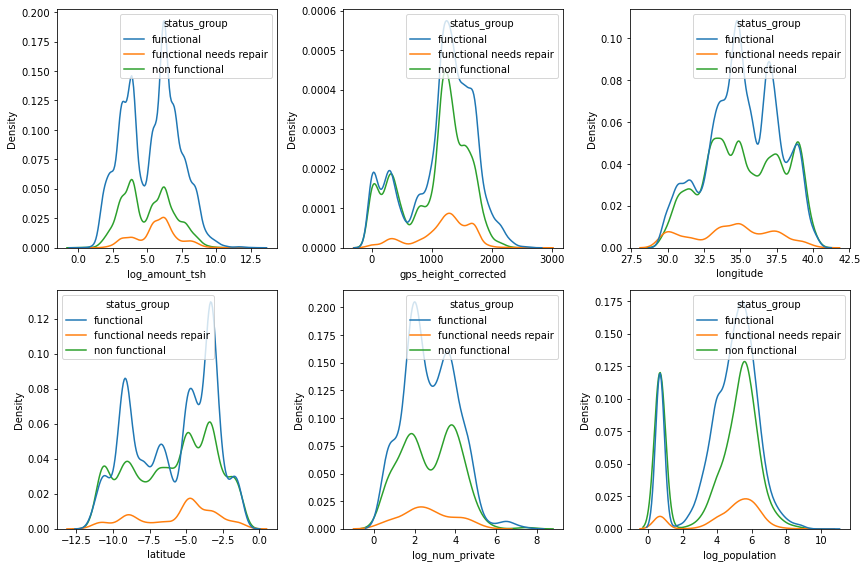

In [39]:
viz.plot_kdes(df, num_cols_list_corrected, 3, exclude_zeros=True)

### Population vs Location:

**Question:**
How does population relate to geographical location? Can the location be used to interpolate missing population values?

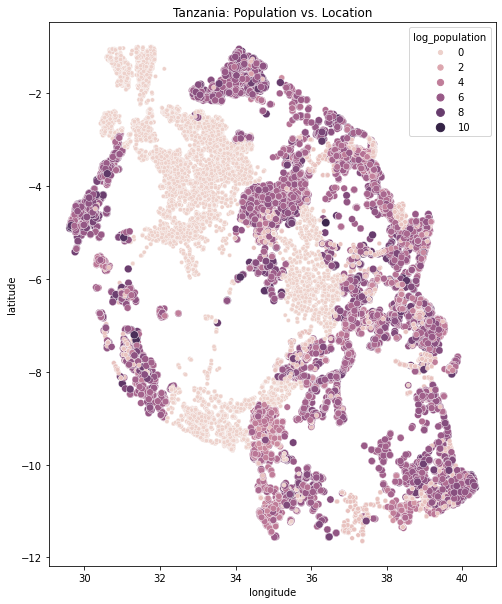

In [40]:
fix, ax = plt.subplots(figsize=(8, 10))
sns.scatterplot(x='longitude', y='latitude', size='log_population', hue='log_population', data=df, ax=ax)
ax.set_title('Tanzania: Population vs. Location')
plt.show()

**Obsevations:** There does appear to be swaths of the country where it is rural, which would explain areas of zero population. Regardless, there is no enough information to interpolate missing population values.

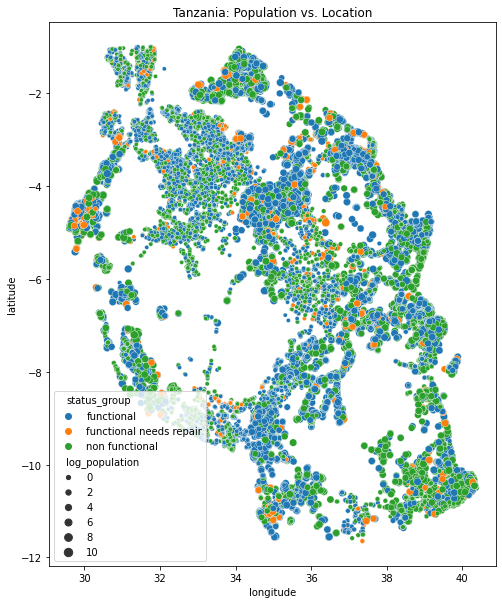

In [41]:
fix, ax = plt.subplots(figsize=(8, 10))
sns.scatterplot(x='longitude', y='latitude', size='log_population', hue='status_group', data=df, ax=ax)
ax.set_title('Tanzania: Population vs. Location')
plt.show()

**Observations:**
There does not appear to be any obvious trends in population nor geographical location with respect to the water pump functional status.

In [42]:
# sns.pairplot(df.loc[:, num_cols_list_corrected+['status_group']], hue='status_group', plot_kws={"s": 5})
# plt.show()

## Summarizing Categorical Data
Next, I will investigate relationships with the categorical variables.

In [43]:
categorical_columns = df.select_dtypes(include=['category']).columns.tolist()

In [44]:
df.loc[:, categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 0 to 74247
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   status_group           59364 non-null  category
 1   funder                 59364 non-null  category
 2   installer              59364 non-null  category
 3   wpt_name               59364 non-null  category
 4   basin                  59364 non-null  category
 5   subvillage             59364 non-null  category
 6   region                 59364 non-null  category
 7   region_code            59364 non-null  category
 8   district_code          59364 non-null  category
 9   lga                    59364 non-null  category
 10  ward                   59364 non-null  category
 11  public_meeting         59364 non-null  category
 12  scheme_management      59364 non-null  category
 13  permit                 59364 non-null  category
 14  construction_year      59364 non-null 

In [45]:
def compute_categorical_counts(df, columns_to_drop=None, print_counts=False):
    categorical_columns = df.select_dtypes(include=['category']).columns.tolist()
    category_counts = {column:len(df[column].value_counts()) for column in categorical_columns}
    sorted_keys = sorted(category_counts, key=category_counts.get, reverse=True)
    category_counts_sorted = {x:category_counts[x] for x in sorted_keys}
    s_cat_count = pd.Series(category_counts_sorted)
    if columns_to_drop is not None:
        s_cat_count.drop(columns_to_drop, inplace=True)
    if print_counts:
        print('Category Counts:')
        print(s_cat_count)
    return s_cat_count

In [46]:
s_cat_count = compute_categorical_counts(df, columns_to_drop=['status_group', 'binned_distance'], print_counts=True)

Category Counts:
wpt_name                 37400
subvillage               19288
installer                 2145
ward                      2092
funder                    1896
lga                        125
construction_year           55
region_code                 27
region                      21
district_code               20
extraction_type             18
extraction_type_group       13
scheme_management           12
management                  12
source                      10
basin                        9
water_quality                8
extraction_type_class        7
payment                      7
payment_type                 7
source_type                  7
waterpoint_type              7
quality_group                6
waterpoint_type_group        6
management_group             5
quantity                     5
quantity_group               5
source_class                 3
public_meeting               2
permit                       2
dtype: int64


### Related Catergorical variables
Inspecting the catergorical variables and their counts above, the following pairs of variables appear to be related:
* `region_code`, `region`
* `extraction_type`, `extraction_type_group`, `extraction_type_class`
* `scheme_management`, `management`
* `source`, `source_type`, `source_class`.
* `payment`, `payment_type`
* `waterpoint_type`, `waterpoint_type_group`
* `management`, `management_group`
* `quantity`, `quantity_group`

In [47]:
column_pairs = [
    ['region', 'region_code'],
    ['extraction_type_class', 'extraction_type_group'],
    ['extraction_type_group', 'extraction_type'],
    ['scheme_management', 'management'],
    ['scheme_management', 'management_group'],
    ['management', 'management_group'],
    ['source', 'source_type'],
    ['source_type', 'source_class'],
    ['payment', 'payment_type'],
    ['waterpoint_type_group', 'waterpoint_type'],
    ['quantity_group', 'quantity']
]

In [48]:
for column_pair in column_pairs:
    count_series = df.groupby(column_pair[0]).apply(lambda x: len(x[column_pair[1]].unique()))
    value_series = df.groupby(column_pair[0]).apply(lambda x: x[column_pair[1]].unique().astype('str'))
    df_cat_summary = pd.DataFrame({f'{column_pair[1]}_count': count_series, f'{column_pair[1]}_values': value_series})
    print(df_cat_summary)

               region_code_count region_code_values
region                                             
Arusha                         2            [2, 24]
Dar es Salaam                  1                [7]
Dodoma                         1                [1]
Iringa                         1               [11]
Kagera                         1               [18]
Kigoma                         1               [16]
Kilimanjaro                    1                [3]
Lindi                          3        [80, 8, 18]
Manyara                        1               [21]
Mara                           1               [20]
Mbeya                          1               [12]
Morogoro                       1                [5]
Mtwara                         3        [99, 90, 9]
Mwanza                         2           [19, 17]
Pwani                          3        [60, 6, 40]
Rukwa                          1               [15]
Ruvuma                         1               [10]
Shinyanga   

**Observations:**
* The following pairs of categorical variables show one-to-one relationships:
    * `management`, `management_group`
    * `payment`, `payment_type`
    * `quantity`, `quantity_group`
* These pairs of categorical variables do not show one-to-one relationships:
    * `region_code`, `region`
    * `extraction_type`, `extraction_type_group`, `extraction_type_class`
    * `scheme_management`, `management`
    * `source`, `source_type`, `source_class`.
    * `waterpoint_type`, `waterpoint_type_group`
* `scheme_management` shows many inconsistancies with `management` and `management_group`.
    
**Plan:**
1. For the one-to-one categorical variables, remove one of the columns to eliminate redundancy in the dataset.
2. For the additional categorical variables, select the variable that is most general in order to keep the model simple. If more information is needed, the more granular variables can be added back later. Evenso, there a couple of more granular columns that I would like to keep as I believe they will be more informative:
    * `source_type`
    * `waterpoint_type`
3. Leave in `scheme_management` since I am not sure which management column to trust.


#### Fix redundacies

In [49]:
redundant_columns = ['management', 'payment', 'quantity']
df_clean = df.drop(columns=redundant_columns)

#### Remove granular columns

In [50]:
granular_columns = ['region_code', 'extraction_type_class', 'extraction_type_group', 'source', 'source_class', 'waterpoint_type_group']
df_clean = df_clean.drop(columns=granular_columns)

### Label Categorical Variables
During modeling, categorical variables will need to be turned into numerical values. Therefore, I will map each categorical variable to a number using scikit-learn's `LabelEncoder()`.

In [51]:
cat_cols_list = df_clean.select_dtypes(include=['category']).columns.to_list()
cat_cols_list.remove('binned_distance')

In [52]:
label_cols_list = [f'{x}_label' for x in cat_cols_list]

In [53]:
for column in cat_cols_list:
    encode_cats = LabelEncoder()
    df_clean[f'{column}_label'] = encode_cats.fit_transform(df_clean[column])

In [54]:
def map_labels(cat_list):
    cat_label_map = {}
    for column in cat_list:
        encode_cats = LabelEncoder()
        unique_cats = df_clean[column].unique().tolist()
        unique_labels = encode_cats.fit_transform(unique_cats).tolist()
        cat_label_map[column] = {k:v for k, v in zip(unique_labels, unique_cats)}
    return cat_label_map

In [55]:
cat_label_map = map_labels(cat_cols_list)

In [56]:
df_clean = df_clean.astype({x:'category' for x in label_cols_list})

In [57]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 0 to 74247
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   status_group             59364 non-null  category
 1   amount_tsh               59364 non-null  float64 
 2   date_recorded            59364 non-null  object  
 3   funder                   59364 non-null  category
 4   gps_height               59364 non-null  int64   
 5   installer                59364 non-null  category
 6   longitude                59364 non-null  float64 
 7   latitude                 59364 non-null  float64 
 8   wpt_name                 59364 non-null  category
 9   num_private              59364 non-null  int64   
 10  basin                    59364 non-null  category
 11  subvillage               59364 non-null  category
 12  region                   59364 non-null  category
 13  district_code            59364 non-null  category
 14  lga   

In [58]:
s_cat_label_count = compute_categorical_counts(df_clean[label_cols_list], columns_to_drop=['status_group_label'], print_counts=True)

Category Counts:
wpt_name_label             37400
subvillage_label           19288
installer_label             2145
ward_label                  2092
funder_label                1896
lga_label                    125
construction_year_label       55
region_label                  21
district_code_label           20
extraction_type_label         18
scheme_management_label       12
basin_label                    9
water_quality_label            8
payment_type_label             7
source_type_label              7
waterpoint_type_label          7
quality_group_label            6
management_group_label         5
quantity_group_label           5
public_meeting_label           2
permit_label                   2
dtype: int64


**Observations:**
For any categorical variable with over 1000 categories, visualizing relationships with the response variable will be too difficult using histograms. Therefore, I will restrict histograms to any categorical variable with fewer than 1000 categories.

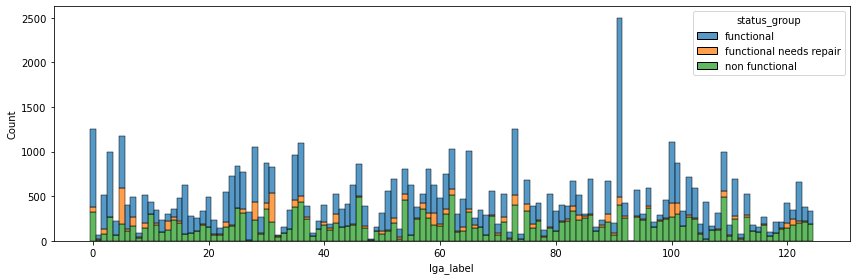

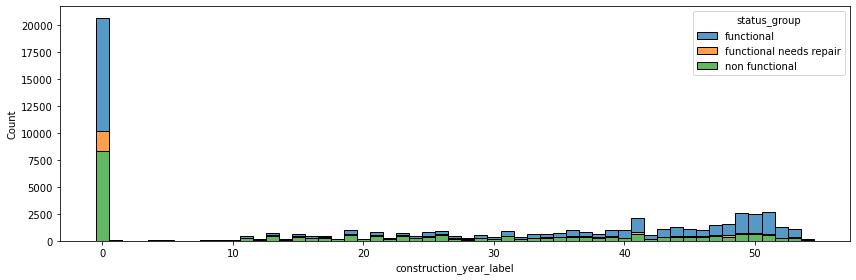

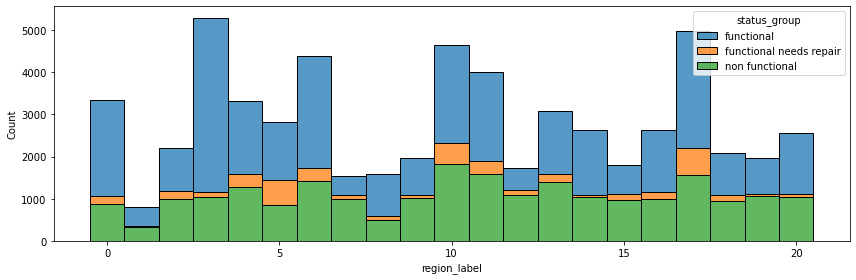

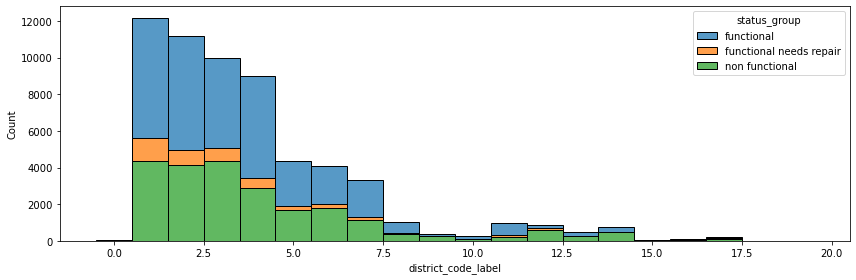

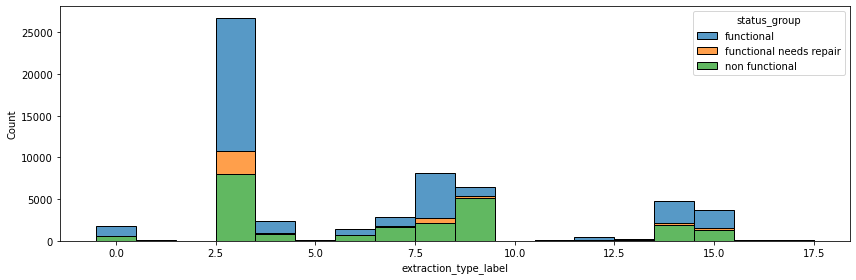

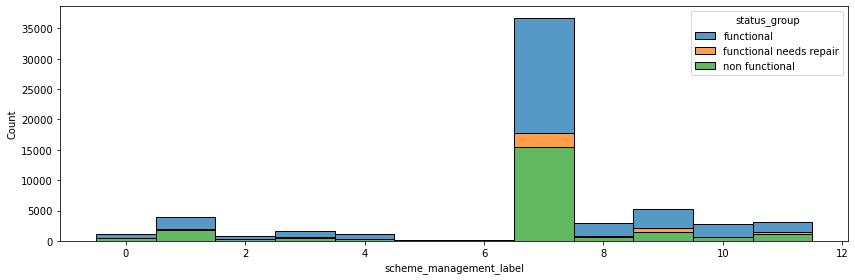

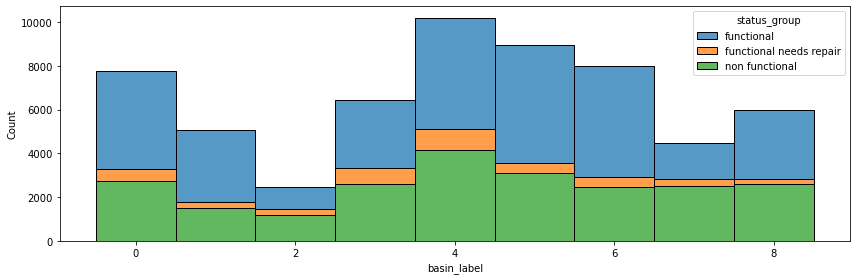

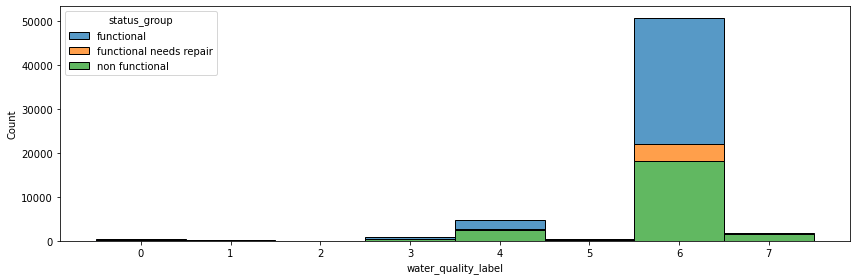

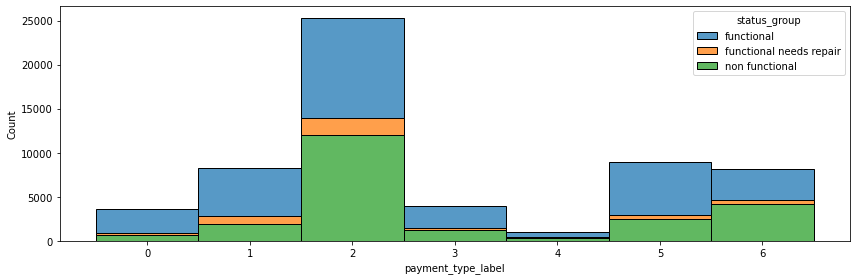

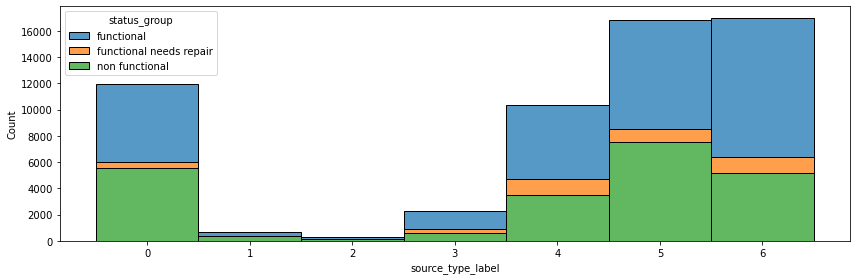

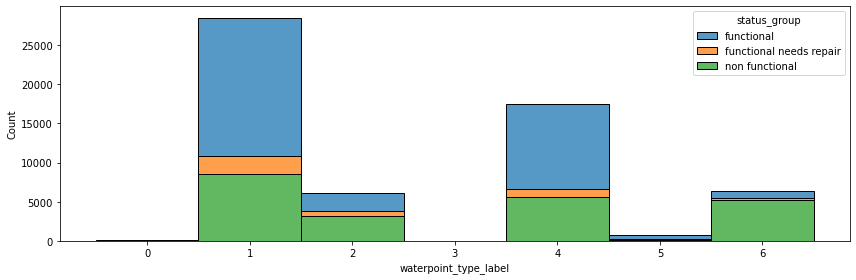

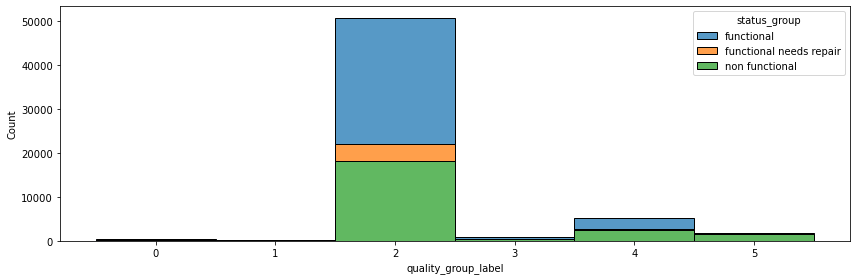

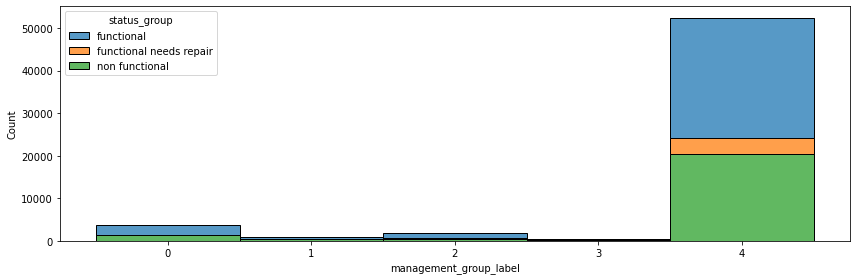

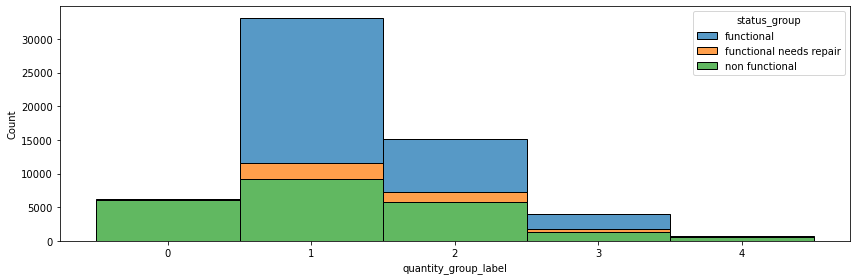

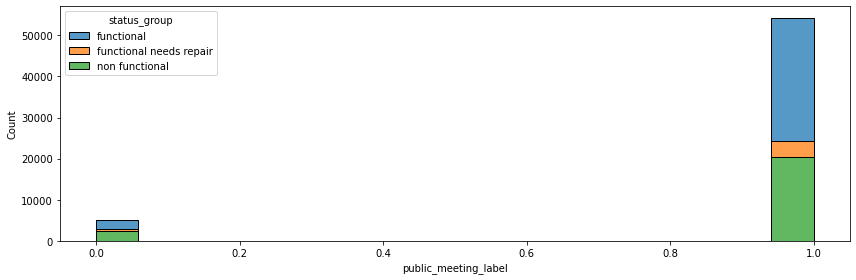

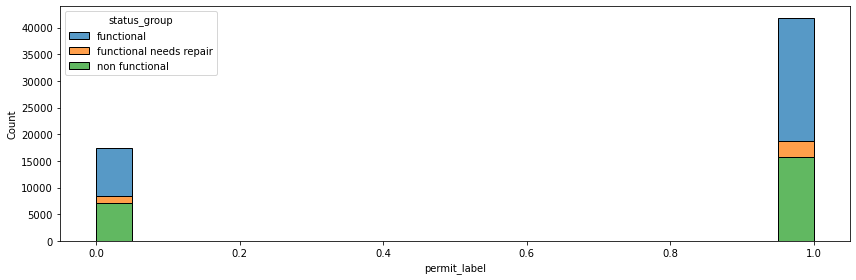

In [59]:
viz.plot_cat_hists(df_clean.loc[:, label_cols_list+['status_group']], s_cat_label_count, 1000, min_count=2, response_var='status_group')

**Observations:**
* `year`
    * There are many zero values for year.
* Many categorical variables include categories with very little data.
* Payment appears to be a big factor on whether the pump is working or not. There is a larger fraction of non-functional water pumps for users who haven't paid.

**Questions:**
* How best to combine catergories? There are some categorical variables with small numbers of some categories. Can these be combined in an inteligent way?

### One-Hot Encode
One-hot encode the categorical variables. This needs to be done so that the machine learning model can work with the categorical variables.

First, create a `DataFrame` with only the labeled categories.

In [76]:
s_cat_count_clean = compute_categorical_counts(df_clean, columns_to_drop=['status_group', 'binned_distance'], print_counts=True)

Category Counts:
wpt_name                   37400
wpt_name_label             37400
subvillage                 19288
subvillage_label           19288
installer                   2145
installer_label             2145
ward                        2092
ward_label                  2092
funder                      1896
funder_label                1896
lga                          125
lga_label                    125
construction_year             55
construction_year_label       55
region                        21
region_label                  21
district_code                 20
district_code_label           20
extraction_type               18
extraction_type_label         18
scheme_management             12
scheme_management_label       12
basin                          9
basin_label                    9
water_quality                  8
water_quality_label            8
payment_type                   7
source_type                    7
waterpoint_type                7
payment_type_label        

In [80]:
label_columns = [x for x in s_cat_count_clean.index.tolist() if 'label' in x]

In [82]:
s_cat_count_clean = s_cat_count_clean.drop(label_columns)

In [83]:
s_cat_count_clean

wpt_name             37400
subvillage           19288
installer             2145
ward                  2092
funder                1896
lga                    125
construction_year       55
region                  21
district_code           20
extraction_type         18
scheme_management       12
basin                    9
water_quality            8
payment_type             7
source_type              7
waterpoint_type          7
quality_group            6
management_group         5
quantity_group           5
public_meeting           2
permit                   2
dtype: int64

Only one-hot encode categorical variables with less than 1000 categories.

In [84]:
one_hot_cats = s_cat_count_clean[s_cat_count_clean < 1000].index.tolist()

In [85]:
one_hot_cats

['lga',
 'construction_year',
 'region',
 'district_code',
 'extraction_type',
 'scheme_management',
 'basin',
 'water_quality',
 'payment_type',
 'source_type',
 'waterpoint_type',
 'quality_group',
 'management_group',
 'quantity_group',
 'public_meeting',
 'permit']

In [86]:
gather_dummy_features = [pd.get_dummies(df_clean[x], drop_first=True) for x in one_hot_cats]
gather_dummy_features.insert(0, df_clean)

In [87]:
df_one_hot = pd.concat(gather_dummy_features, axis=1)

In [88]:
df_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 0 to 74247
Columns: 350 entries, status_group to True
dtypes: category(45), float64(8), int64(3), object(1), uint8(293)
memory usage: 31.1+ MB


### Response Variable
Lastly, I will consider the response variable.

In [ ]:
df['status_group'].value_counts(normalize=True)

**Obsesrvations:**
* The 'functional needs repair' status group only cosists of 7% of the dataset. But, since these pumps are still working, I will lump them with 'functional'.

In [ ]:
df['status_group_combined'] = df['status_group'].replace({'functional needs repair': 'functional'})

In [ ]:
df['status_group_combined'].value_counts(normalize=True)

## Summary
In this notebook, I investigated the numerical and categorical variables in the waterpump dataset. I made the following observations:
* numerical variables:
    * There were many zero values for location and geographical heights fields. I corrected for these missing values by using median values for nearby points.
    * The variables `amount_tsh`, `num_private`, and `population` show CDFs that are heavily skewed towards zero. I corrected for this skew by performing a log transform.
    * There does not appear to be any obvious trends in population nor geographical location with respect to the water pump functional status.
* categorical variables:
    * Several categorical variables contained related quanties. Of these related variables, I picked those that were most general. This way I can analyze feature importance on a more macro level before diving into too much detail.
    * I performed feature engineering to convert categorical variables into one-hot vectors.
    * Inspecting the categorical variables with respect to the response variable, I observed a trend in payment. For those pumps lacking payment, there was a larger fraction of pumps that were not functional.
* response variable:
    * At the end, I investigated the distribution of the response variable. The status group 'functional needs repair' only applies to 7% of values in the dataset. Therefore, I decided to lump this group with the 'functional' group, to create a binary response variable.